# Options Pricing
In this notebook, we are looking at options pricing for different types of options.

In [1]:
# Import all the necassary libs
import numpy as np
# import pandas as pd
# pd.set_option('display.width', 320)
# pd.set_option('display.max_rows', 100)
# pd.options.display.float_format = '{:,.2f}'.format
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import animation
import matplotlib.patches as patches

# Options Class Object

In [2]:
class Option(object):
    def __init__(self, S, K, r, sigma, dividend, T, type_option):
        # set values
        self.S = S         # underlying asset price
        self.K = K         # option strike price
        self.r = r         # continuous risk-free return rate
        self.sigma = sigma # volatility of underlying asset
        self.D = dividend  # dividend rate
        self.T = T         # expriy time (in years)
        self.option_type = type_option # option type: (C)all or (P)ut
        # calculated values
        self.d1 = ( np.log(S/K) + (r-D+0.5*sigma**2)*T )/( sigma*np.sqrt(T) )
        self.d2 = ( np.log(S/K) + (r-D-0.5*sigma**2)*T )/( sigma*np.sqrt(T) )
    
    
    def N( self, x ):
        return norm.cdf(x)
    
    
    def dN( self, x ):
        return norm.pdf(x)
    
    
    def Get_BSM_Value( self ):
        """
        Black Scholes equation used for calculating the 
        value of an option.

        INPUTS:
                S: spot price
                K: strike price
            sigma: volatility
                T: expiry time
              tau: T - t, time to expiry

        OUTPUT:
            value: price of option

        """
        if self.option_type == "C":   # CALL OPTION
            return self.S*self.N( self.d1 )*np.exp(-self.D*self.T) - self.K*self.N( self.d2 )*np.exp(-self.r*self.T)

        elif self.option_type == "P": # PUT OPTION
            return -self.S*self.N( -self.d1 )*np.exp(-self.D*self.T) + self.K*self.N( -self.d2 )*np.exp(-self.r*self.T)
        
    
    def Get_Delta( self ):
        """
        This is the sensitivity to the underlying asset.
        """
        if self.option_type == 'C':
            return np.exp( -self.D*self.T )*self.N( self.d1 )
            
        elif self.option_type == 'P':
            return np.exp( -self.D*self.T )*(self.N( self.d1 ) - 1)
        
    
    def Get_Gamma( self ):
        """
        This is the sensitivity of Delta to the underlying asset.
        The rate of change of delta with respect to the underlying 
        asset's price.
        """
        # Gamma is the same for both Call or Put
        return ( np.exp( -self.D*self.T )*self.dN( self.d1 ) 
               )/( self.sigma*self.S*np.sqrt(self.T) )


    def Get_Theta( self ):
        """
        This is the sensitivity of the Option value to time
        """
        d1 = self.d1
        d2 = d1 - self.sigma*np.sqrt( self.T )
        
        N1 = self.N( d1 )
        N2 = self.N( d2 )
        dN1= self.dN( d1 )
        
        nN1 = self.N( -d1 )
        nN2 = self.N( -d2 )
        ndN1= self.dN( -d1 )
        
        S = self.S
        K = self.K
        D = self.D
        r = self.r
        o = self.sigma
        T = self.T
        expDT = np.exp( -D*T )
        
        if self.option_type == 'C':
            return -(o*S*expDT*dN1)/(2.0*np.sqrt(T)) + (D*S*N1*expDT) - (r*K*expDT*N2)
        elif self.option_type == 'P':
            return -(o*S*expDT*ndN1)/(2.0*np.sqrt(T)) + (D*S*nN1*expDT) - (r*K*expDT*nN2)
    
    
    def Get_Speed( self ):
        """
        This is the sensitivity of Gamma to the underlying asset
        """
        d1 = self.d1
        d2 = d1 - self.sigma*np.sqrt( self.T )
        
        dN1= self.dN( d1 )
        
        S = self.S
        K = self.K
        D = self.D
        r = self.r
        o = self.sigma
        T = self.T
        expDT = np.exp( -D*T )
        
        return -((expDT*dN1)/(o*o*S*S*T))*(d1 + o*np.sqrt(T))
        
    
    def Get_Vega( self ):
        """
        This is the senstivity of the value of the option 
        with respect to volatility.
        """
        return self.S * np.sqrt( self.T ) * np.exp( -self.D*self.T )*self.dN( self.d1 )
    
    
    def Get_Rho_r( self ):
        """
        This is the sensitivity to the interest rate.
        """
        if self.option_type == 'C':
            return self.K*self.T*np.exp( -self.r*self.T )*self.N( self.d2 )
        elif self.option_type == 'P':
            return -self.K*self.T*np.exp( -self.r*self.T )*self.N( -self.d2 )
            
    
    def Get_Rho_D( self ):
        """
        This is the sensitivity to the dividend yield.
        """
        if self.option_type == 'C':
            return -self.T*self.S*np.exp( -self.D*self.T )*self.N( self.d1 )
        elif self.option_type == 'P':
            return self.T*self.S*np.exp( -self.D*self.T )*self.N( -self.d1 )


# Binary Option

In [3]:
# Binary option object
class BinaryOption( object ):
    def __init__(self, S, K, r, sigma, dividend, T, type_option):
        # set values
        self.S = S         # underlying asset price
        self.K = K         # option strike price
        self.r = r         # continuous risk-free return rate
        self.sigma = sigma # volatility of underlying asset
        self.D = dividend  # dividend rate
        self.T = T         # expriy time (in years)
        self.option_type = type_option # option type: (C)all or (P)ut
        # calculated values
        self.d1 = ( np.log(S/K) + (r+0.5*sigma**2)*T )/( sigma*np.sqrt(T) )
        self.d2 = self.d1 - sigma*np.sqrt( T )
    
    
    def N( self, x ):
        return norm.cdf(x)
    
    
    def dN( self, x ):
        return norm.pdf(x)
    
    
    def Get_BSM_Value(self):
        if self.option_type == 'C':
            return np.exp( -self.r*self.T )*self.N( self.d2 )
        elif self.option_type == 'P':
            return np.exp( -self.r*self.T )*(1.0 - self.N( self.d2 ))
    
    
    def Get_Delta(self):
        tmp = (np.exp( -self.r*self.T )*self.dN( self.d2 ))/(self.sigma*self.S*np.sqrt( self.T ))
        
        if self.option_type == 'C':
            return tmp
        elif self.option_type == 'P':
            return -tmp
        
    def Get_Gamma(self):
        tmp = (np.exp( -self.r*self.T )*self.d1*self.dN( self.d2 ))/((self.sigma**2)*(self.S**2)*self.T)
        
        if self.option_type == 'C':
            return -tmp
        elif self.option_type == 'P':
            return tmp

        
    def Get_Theta(self):
        d1 = self.d1
        d2 = d1 - self.sigma*np.sqrt( self.T )
        N1 = self.N( d1 )
        N2 = self.N( d2 )
        dN1= self.dN( d1 )
        dN2= self.dN( d2 )
        nN1 = self.N( -d1 )
        nN2 = self.N( -d2 )
        ndN1= self.dN( -d1 )
        
        S = self.S
        K = self.K
        D = self.D
        r = self.r
        o = self.sigma
        T = self.T
        expDT = np.exp( -D*T )
        b = np.exp( -self.r*self.T )*dN2
        c = ( (d1/(2.0*T)) - ((r-D)/(o*np.sqrt(T))) )
        if self.option_type == 'C':
            a = self.r*np.exp( -self.r*self.T )*N2
            return a + b*c
        elif self.option_type == 'P':
            a = self.r*np.exp( -self.r*self.T )*(1.0-N2)
            return a - b*c
        
        
    def Get_Speed(self):
        a = -2.0*self.d1 + (1.0-self.d1*self.d2)/(self.sigma*np.sqrt(self.T))
        
        tmp = ( (np.exp( -self.r*self.T )*self.dN(self.d2))/( self.sigma**2 * self.S**3 *self.T ) )*a
        
        if self.option_type == 'C':
            return -tmp
        elif self.option_type == 'P':
            return tmp
    
    
    def Get_Vega(self):
        tmp = np.exp( -self.r*self.T )*self.dN(self.d2)*( np.sqrt(self.T) + self.d2/self.sigma ) 
        
        if self.option_type == 'C':
            return -tmp
        elif self.option_type == 'P':
            return tmp
    
    
    def Get_Rho_r(self):

        b = ( np.sqrt(self.T)/self.sigma )*np.exp( -self.r*self.T )*self.dN( self.d2 )
        
        if self.option_type == 'C':
            a = -self.T*np.exp( -self.r*self.T )*self.N( self.d2 )
            return a + b
        elif self.option_type == 'P':
            a = -self.T*np.exp( -self.r*self.T )*( 1.0 - self.N( self.d2 ) )
            return a - b
        
    def Get_Rho_D(self):
        #tmp = (np.sqrt(T)/self.sigma)*np.exp( -self.r*self.T )*self.dN( self.d2 )
        #print(np.shape(tmp))
        #if self.option_type == 'C':
        #    return -1.0*tmp
        #elif self.option_type == 'P':
        #    return tmp
        return 0.0



In [4]:
def print_greeks( option ):
    print("---- The Greeks ----")
    print('Value: 'f'{option.Get_BSM_Value():9.4f}')
    print('-')
    print('Delta: 'f'{option.Get_Delta():9.4f}')
    print('Gamma: 'f'{option.Get_Gamma():9.4f}')
    print('Theta: 'f'{option.Get_Theta():9.4f}')
    print('Speed: 'f'{option.Get_Speed():9.4f}')
    print(' Vega: 'f'{option.Get_Vega():9.4f}')
    print('Rho_r: 'f'{option.Get_Rho_r():9.4f}')
    print('Rho_D: 'f'{option.Get_Rho_D():9.4f}')

# Let's look at some charts

In [5]:
#  ===============
#  Main
#  ===============
S = 100
K = 100
r = 0.0
o = 0.1
D = 0.0
T = 1.0 # years


call_option = Option(S,K,r,o,D,T,'C')
put_option = Option(S,K,r,o,D,T,'P')


print_greeks( call_option )
print("") #  empty line 
print_greeks( put_option )
print("") #  empty line 

---- The Greeks ----
Value:    3.9878
-
Delta:    0.5199
Gamma:    0.0398
Theta:   -1.9922
Speed:   -0.0006
 Vega:   39.8444
Rho_r:   48.0061
Rho_D:  -51.9939

---- The Greeks ----
Value:    3.9878
-
Delta:   -0.4801
Gamma:    0.0398
Theta:   -1.9922
Speed:   -0.0006
 Vega:   39.8444
Rho_r:  -51.9939
Rho_D:   48.0061



# The Greeks (2D lines)

In [6]:
K = 100
S = np.arange(K-30,K+31,0.5)

r = 0.1
o = 0.1
D = 0.0
#T = np.arange(0.01,1.005,0.025)
T = np.logspace(3, 2, 6, endpoint=True)/1000
T = np.flip(T)
#print(S)
#print(np.shape(S))
print(T)
print(np.shape(T))

[0.1        0.15848932 0.25118864 0.39810717 0.63095734 1.        ]
(6,)


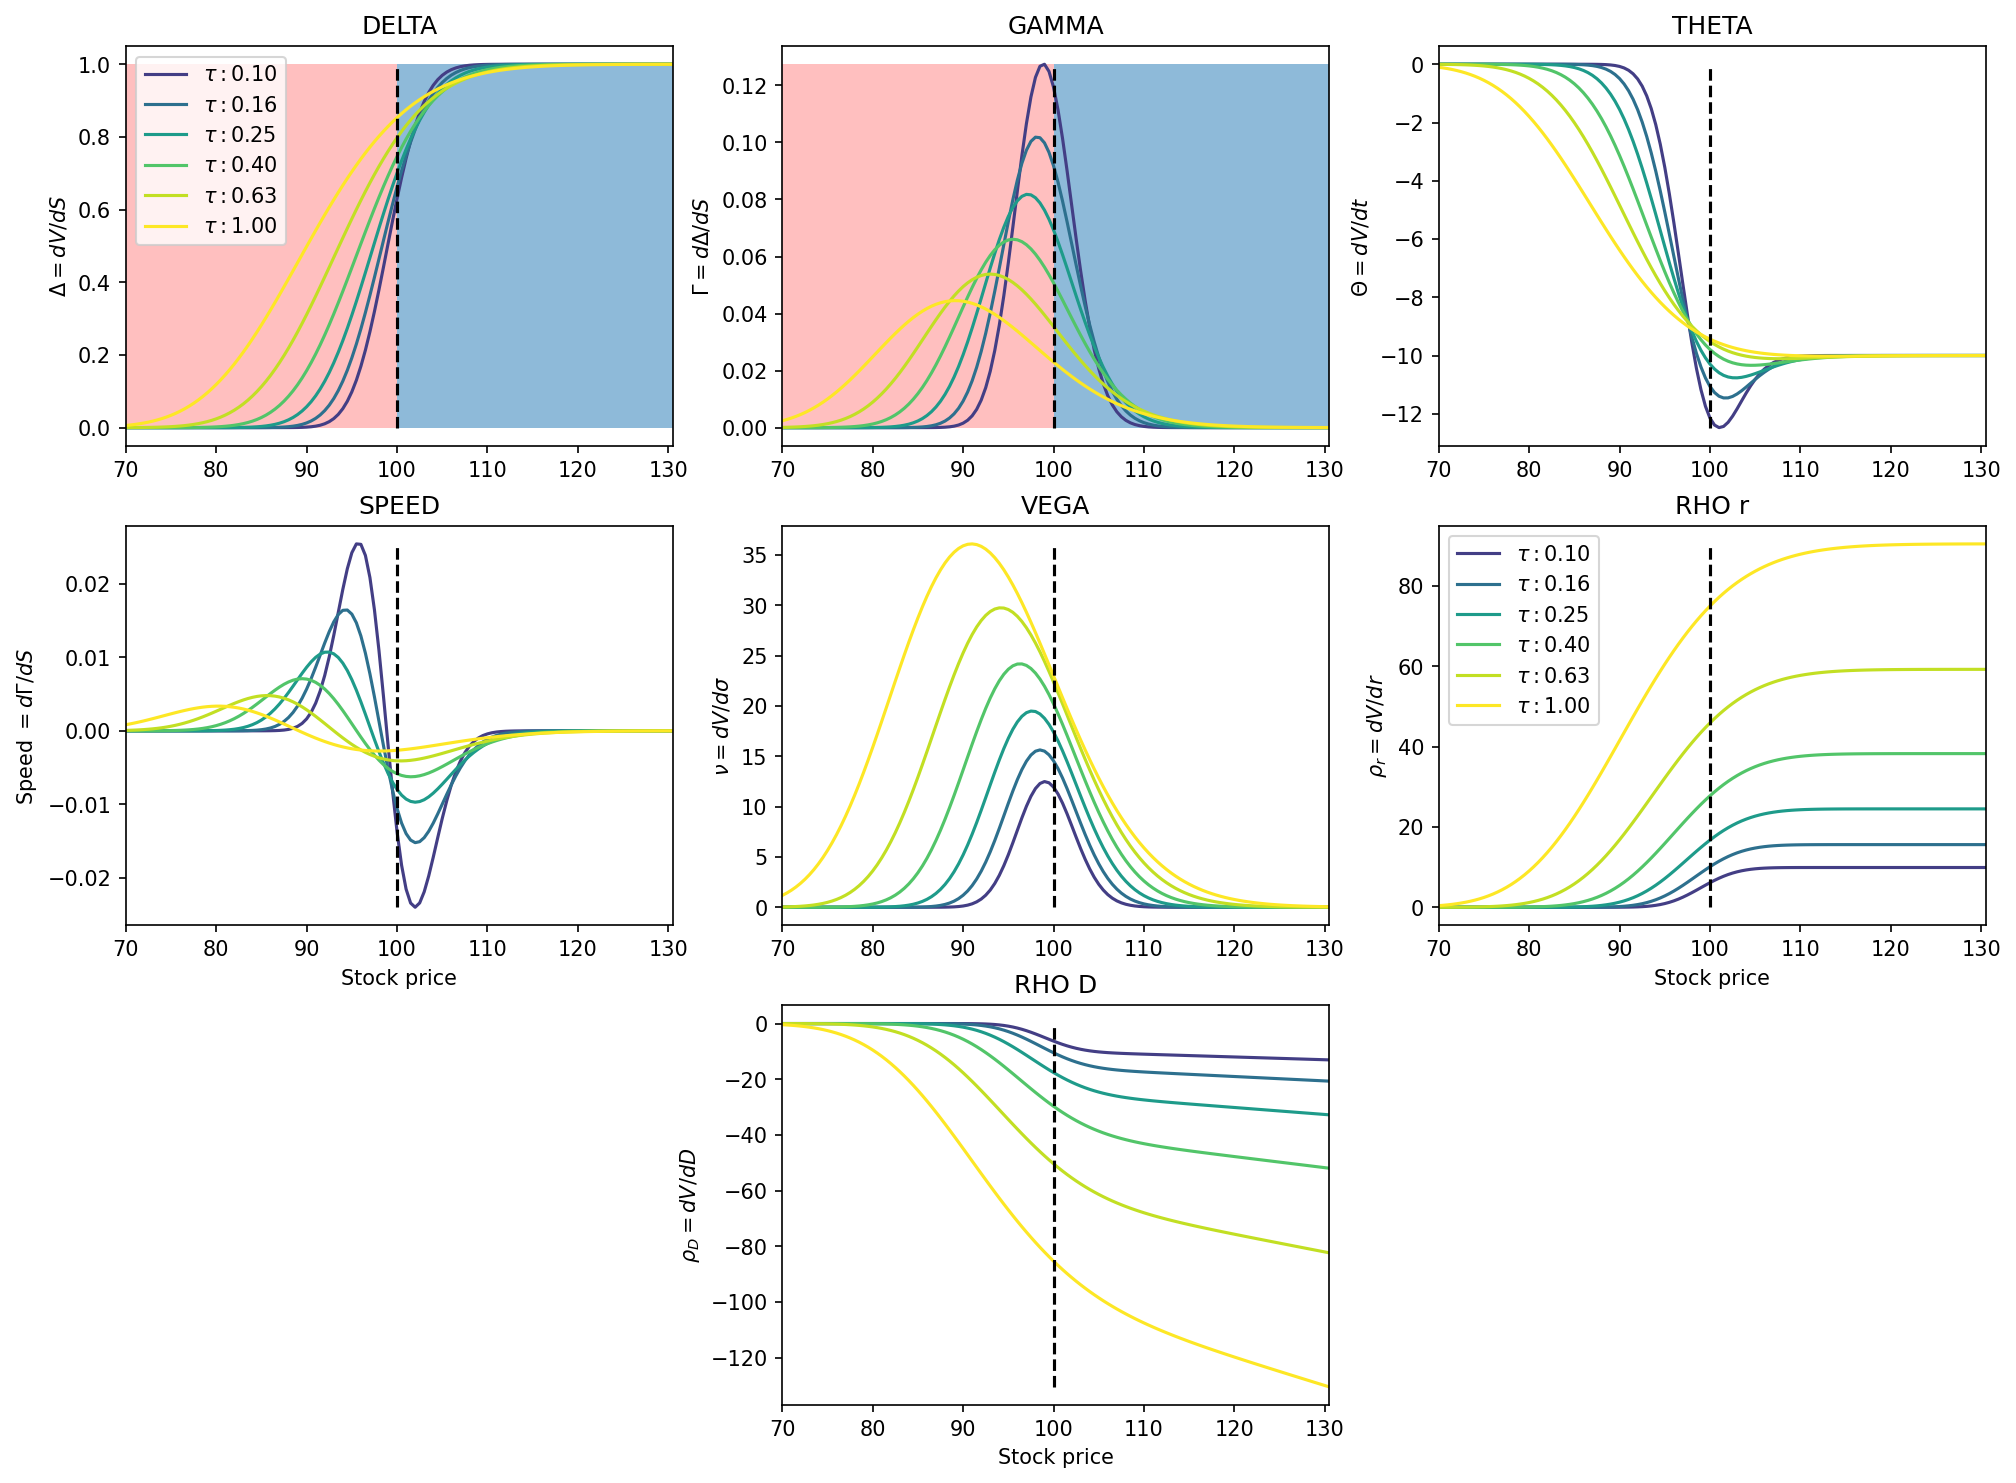

In [7]:
deltas_call = np.zeros((len(S),len(T)))
gammas_call = np.zeros((len(S),len(T)))
thetas_call = np.zeros((len(S),len(T)))
speeds_call = np.zeros((len(S),len(T)))
vegas_call  = np.zeros((len(S),len(T)))
rho_rs_call = np.zeros((len(S),len(T)))
rho_ds_call = np.zeros((len(S),len(T)))

viridis = cm.get_cmap('viridis', 12)
v = viridis( np.linspace(0, 1, len(T)+1) )

fig, axes = plt.subplots(nrows=3,
                         ncols=3,
                         figsize=(16, 12),
                         dpi=150
                        )


for j in range(0,len(T)):
    for i in range(0,len(S)):
        tmp_option = Option(S[i],K,r,o,D,T[j],"C")
        deltas_call[i,j] = tmp_option.Get_Delta()
        gammas_call[i,j] = tmp_option.Get_Gamma()
        thetas_call[i,j] = tmp_option.Get_Theta()
        speeds_call[i,j] = tmp_option.Get_Speed()
        vegas_call[i,j]  = tmp_option.Get_Vega()
        rho_rs_call[i,j] = tmp_option.Get_Rho_r()
        rho_ds_call[i,j] = tmp_option.Get_Rho_D()

    axes[0][0].plot(S, deltas_call[:,j],color=v[j+1],label=r"$\tau: %.2f$"%T[j])
    axes[0][1].plot(S, gammas_call[:,j],color=v[j+1])
    axes[0][2].plot(S, thetas_call[:,j],color=v[j+1])
    axes[1][0].plot(S, speeds_call[:,j],color=v[j+1])
    axes[1][1].plot(S,  vegas_call[:,j],color=v[j+1])
    axes[1][2].plot(S, rho_rs_call[:,j],color=v[j+1],label=r"$\tau: %.2f$"%T[j])
    axes[2][1].plot(S, rho_ds_call[:,j],color=v[j+1])


axes[0][0].legend()
axes[1][2].legend()

axes[0][0].plot([K,K],[0,1],'k--')
axes[0][1].plot([K,K],[np.amin(gammas_call) ,np.amax(gammas_call) ],'k--')
axes[0][2].plot([K,K],[np.amin(thetas_call) ,np.amax(thetas_call) ],'k--')
axes[1][0].plot([K,K],[np.amin(speeds_call) ,np.amax(speeds_call) ],'k--')
axes[1][1].plot([K,K],[np.amin( vegas_call) ,np.amax( vegas_call) ],'k--')
axes[1][2].plot([K,K],[np.amin(rho_rs_call) ,np.amax(rho_rs_call) ],'k--')
axes[2][1].plot([K,K],[np.amin(rho_ds_call) ,np.amax(rho_ds_call) ],'k--')


axes[0][0].set_xlim(S[0],S[-1])
axes[0][0].set_ylabel(r'$\Delta = dV/dS$')
axes[0][0].set_title('DELTA')
axes[0][0].add_patch(patches.Rectangle((K, 0), S[-1]-K, np.amax(deltas_call)-np.amin(deltas_call), alpha = 0.5))
axes[0][0].add_patch(patches.Rectangle((S[0], 0),  K-S[0], np.amax(deltas_call)-np.amin(deltas_call), alpha = 0.25, fc = "Red"))

axes[0][1].set_xlim(S[0],S[-1])
axes[0][1].set_ylabel(r'$\Gamma = d\Delta/dS$')
axes[0][1].set_title('GAMMA')
axes[0][1].add_patch(patches.Rectangle((K, 0), S[-1]-K, np.amax(gammas_call)-np.amin(gammas_call), alpha = 0.5))
axes[0][1].add_patch(patches.Rectangle((S[0], 0),  K-S[0], np.amax(gammas_call)-np.amin(gammas_call), alpha = 0.25, fc = "Red"))

axes[0][2].set_xlim(S[0],S[-1])
axes[0][2].set_ylabel(r'$\Theta = dV/dt$')
axes[0][2].set_title('THETA')

axes[1][0].set_xlim(S[0],S[-1])
axes[1][0].set_ylabel(r'Speed $= d\Gamma/dS$')
axes[1][0].set_title('SPEED')
axes[1][0].set_xlabel('Stock price')

axes[1][1].set_xlim(S[0],S[-1])
axes[1][1].set_ylabel(r'$\nu = dV/d\sigma$')
axes[1][1].set_title('VEGA')

axes[1][2].set_xlim(S[0],S[-1])
axes[1][2].set_ylabel(r'$\rho_r = dV/dr$')
axes[1][2].set_title('RHO r')
axes[1][2].set_xlabel('Stock price')

axes[2][1].set_xlim(S[0],S[-1])
axes[2][1].set_ylabel(r'$\rho_D = dV/dD$')
axes[2][1].set_title('RHO D')
axes[2][1].set_xlabel('Stock price')


fig.delaxes(axes[2][0])
fig.delaxes(axes[2][2])

In [11]:
# Stock price can be in a range...
S0_lower = 50
S0_upper = 150
K = 110 # strike price
r = 0.1 # interest rate
o = 0.5 # volatility
D = 0.0 # dividend yield
T = 1.0 # years

#  Our time vector 
dt = 0.01
t = dt


time = np.arange( t, T+dt, dt) 
#  time should be a vector with 100 rows


#  in that time (from now to maturity), the stock price
#  will rise from S0_lower=10 to ST=100
S = np.array([range(S0_lower,S0_upper,1) for i in range(len(time))])
#  for each time unit the stock price goes from S0->ST
#  so we should have a matrix with dimensions (100,90)


#  now create a matrix of ones that will come in handy later
I = np.ones((np.shape(S)))
#  this has the same dimensions as S
#  so we should have a matrix with dimensions (100,90)


#  Now we need a matrix which has the time units arranged 
#  such that each column goes from [0.01 to 1.0]
#  so we should have a matrix with dimensions (100,90)
T = np.array( [x for x in time for i in range( np.shape(S)[1] )] ).reshape(np.shape(S))
#  This is our time matrix and the resolution of 
#  this matrix will affect the surfaces we generate later.
#  This is the time TO maturity

In [12]:
def Get_Greeks( option_flavour ):
    options = []

    for i in range(np.shape(S)[0]):       # for each row (time)
        #print('-',end = '')
        for j in range(np.shape(S)[1]):   # for each column (price)
            #if j%50==0:
            #    print('.',end = '')
            
            if option_flavour == 'call_european':
                options.append( Option(S[i,j],
                                       K*I[i,j],
                                       r*I[i,j],
                                       o*I[i,j],
                                       D*I[i,j],
                                       T[i,j],
                                       'C'))
            elif option_flavour == 'put_european':
                options.append( Option(S[i,j],
                                       K*I[i,j],
                                       r*I[i,j],
                                       o*I[i,j],
                                       D*I[i,j],
                                       T[i,j],
                                       'P'))
            elif option_flavour == 'call_binary':
                options.append( BinaryOption(S[i,j],
                                       K*I[i,j],
                                       r*I[i,j],
                                       o*I[i,j],
                                       D*I[i,j],
                                       T[i,j],
                                       'C'))
            elif option_flavour == 'put_binary':
                options.append( BinaryOption(S[i,j],
                                       K*I[i,j],
                                       r*I[i,j],
                                       o*I[i,j],
                                       D*I[i,j],
                                       T[i,j],
                                       'P'))
    print(np.shape(options))
            
    greeks = {}
    greeks['delta'] = [ x.Get_Delta() for x in options ]
    greeks['delta'] = np.array(greeks['delta']).reshape(np.shape(S))
    print(np.shape(greeks['delta']))

    greeks['gamma'] = [ x.Get_Gamma() for x in options ]
    greeks['gamma'] = np.array(greeks['gamma']).reshape(np.shape(S))
    print(np.shape(greeks['gamma']))

    greeks['theta'] = [ x.Get_Theta() for x in options ]
    greeks['theta'] = np.array(greeks['theta']).reshape(np.shape(S))
    print(np.shape(greeks['theta']))

    greeks['speed'] = [ x.Get_Speed() for x in options ]
    greeks['speed'] = np.array(greeks['speed']).reshape(np.shape(S))
    print(np.shape(greeks['speed']))

    greeks['vega'] = [ x.Get_Vega() for x in options ]
    greeks['vega'] = np.array(greeks['vega']).reshape(np.shape(S))
    print(np.shape(greeks['vega']))

    greeks['rho_r'] = [ x.Get_Rho_r() for x in options ]
    greeks['rho_r'] = np.array(greeks['rho_r']).reshape(np.shape(S))
    print(np.shape(greeks['rho_r']))

    greeks['rho_D'] = [ x.Get_Rho_D() for x in options ]
    print(np.shape(greeks['rho_D']))
    greeks['rho_D'] = np.array(greeks['rho_D']).reshape(np.shape(S))
    print(np.shape(greeks['rho_D']))
    
    return greeks
    

In [13]:
def plot_3D( greek , greek_str ):
    
    row_count = 200
    col_count = 200
    
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(33,290)
    ax.plot_wireframe(S, T, greek, rcount=row_count, ccount=col_count, alpha=0.0)
    ax.plot_surface(S, T, greek, facecolors=cm.jet(delta), 
                    linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    ax.set_zlim3d(greek.min(), greek.max())
    ax.set_xlabel('Stock price ($)')
    ax.set_ylabel('Time to Expiration (years)')
    ax.set_zlabel(greek_str)
    
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array( greek )
    cbar = plt.colorbar(m, shrink=0.7)
    cbar.set_label(greek_str)
    

In [14]:
def plot_3D_grid(g1,g1_str,
                 g2,g2_str,
                 g3,g3_str,
                 g4,g4_str,
                 g5,g5_str,
                 g6,g6_str,
                 g7,g7_str):
    
    row_count = 200
    col_count = 200
    
    # Set up Figure and Axes in one function call
    fig, axes = plt.subplots(nrows=3,
                             ncols=3,
                             figsize=(16, 12),
                             subplot_kw=dict(projection='3d')
                            )
    
    #=========================================
    # DELTA 
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[0][0].view_init(33,290)
    axes[0][0].plot_wireframe(S, T, g1, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[0][0].plot_surface(S, T, g1, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[0][0].set_zlim3d(g1.min(), g1.max())
    axes[0][0].set_xlabel('Stock price ($)')
    axes[0][0].set_ylabel('Time to Expiration (years)')
    axes[0][0].set_zlabel(g1_str)
    
    #=========================================
    # GAMMA
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[0][1].view_init(33,290)
    axes[0][1].plot_wireframe(S, T, g2, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[0][1].plot_surface(S, T, g2, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[0][1].set_zlim3d(g2.min(), g2.max())
    axes[0][1].set_xlabel('Stock price ($)')
    axes[0][1].set_ylabel('Time to Expiration (years)')
    axes[0][1].set_zlabel(g2_str)
    
    #=========================================
    # THETA
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[0][2].view_init(33,290)
    axes[0][2].plot_wireframe(S, T, g3, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[0][2].plot_surface(S, T, g3, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[0][2].set_zlim3d(g3.min(), g3.max())
    axes[0][2].set_xlabel('Stock price ($)')
    axes[0][2].set_ylabel('Time to Expiration (years)')
    axes[0][2].set_zlabel(g3_str)
    
    #=========================================
    # SPEED
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[1][0].view_init(33,290)
    axes[1][0].plot_wireframe(S, T, g4, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[1][0].plot_surface(S, T, g4, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[1][0].set_zlim3d(g4.min(), g4.max())
    axes[1][0].set_xlabel('Stock price ($)')
    axes[1][0].set_ylabel('Time to Expiration (years)')
    axes[1][0].set_zlabel(g4_str)
    
    #=========================================
    # VEGA
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[1][1].view_init(33,290)
    axes[1][1].plot_wireframe(S, T, g5, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[1][1].plot_surface(S, T, g5, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[1][1].set_zlim3d(g5.min(), g5.max())
    axes[1][1].set_xlabel('Stock price ($)')
    axes[1][1].set_ylabel('Time to Expiration (years)')
    axes[1][1].set_zlabel(g5_str)
    
    #=========================================
    # RHO_r
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[1][2].view_init(33,290)
    axes[1][2].plot_wireframe(S, T, g6, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[1][2].plot_surface(S, T, g6, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[1][2].set_zlim3d(g6.min(), g6.max())
    axes[1][2].set_xlabel('Stock price ($)')
    axes[1][2].set_ylabel('Time to Expiration (years)')
    axes[1][2].set_zlabel(g6_str)
    
    
    #=========================================
    # RHO_D
    #=========================================
    norm = matplotlib.colors.Normalize()
    axes[2][1].view_init(33,290)
    axes[2][1].plot_wireframe(S, T, g7, 
                              rcount=row_count, ccount=col_count, alpha=0.0)
    axes[2][1].plot_surface(S, T, g7, cmap=cm.coolwarm, 
                            linewidth=0.01, rcount=row_count, ccount=col_count, alpha = 1)
    
    axes[2][1].set_zlim3d(g7.min(), g7.max())
    axes[2][1].set_xlabel('Stock price ($)')
    axes[2][1].set_ylabel('Time to Expiration (years)')
    axes[2][1].set_zlabel(g7_str)

    fig.delaxes(axes[2][0])
    fig.delaxes(axes[2][2])

(10000,)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(10000,)
(100, 100)


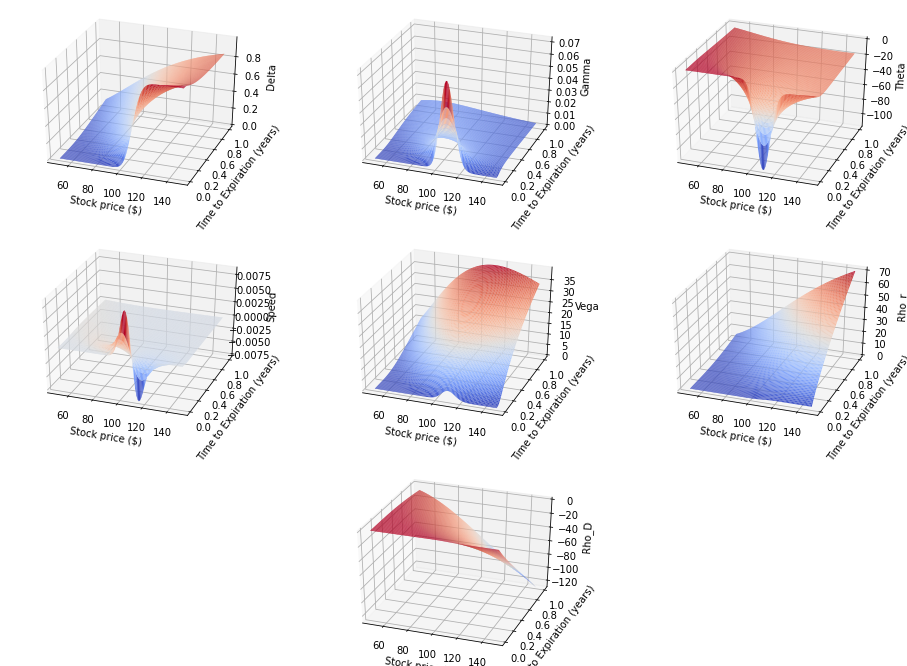

In [15]:
greeks = Get_Greeks( 'call_european' )
plot_3D_grid(greeks['delta'],"Delta",
            greeks['gamma'],"Gamma",
            greeks['theta'],"Theta",
            greeks['speed'],"Speed",
            greeks['vega'],"Vega",
            greeks['rho_r'],"Rho_r",
            greeks['rho_D'],"Rho_D")

# V vs interest rate

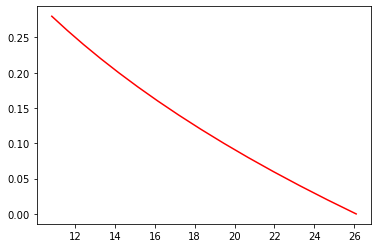

In [16]:
# plot V vs r
r = np.arange(0.0, 0.3,0.02)

# Stock price can be in a range...
S = 100
K = 110 # strike price
o = 0.5 # volatility
D = 0.0 # dividend yield
T = 1.0 # years

option = []
for ir in r:
    option.append( Option(S,K,ir,o,D,T,'P'))

value = [ x.Get_BSM_Value() for x in option ]

fig = plt.figure()

plt.plot(value, r, 'r-')
plt.show()

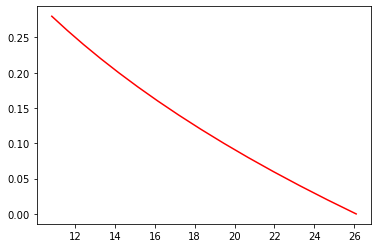

In [17]:
# plot V vs r
o = np.arange(0.0, 0.3,0.02)

# Stock price can be in a range...
S = 100
K = 110 # strike price
o = 0.5 # volatility
D = 0.0 # dividend yield
T = 1.0 # years

option = []
for ir in r:
    option.append( Option(S,K,ir,o,D,T,'P'))

value = [ x.Get_BSM_Value() for x in option ]

fig = plt.figure()

plt.plot(value, r, 'r-')
plt.show()

In [18]:
greeks = Get_Greeks( 'put_european' )

plot_3D_grid(greeks['delta'],"Delta",
            greeks['gamma'],"Gamma",
            greeks['theta'],"Theta",
            greeks['speed'],"Speed",
            greeks['vega'],"Vega",
            greeks['rho_r'],"Rho_r",
            greeks['rho_D'],"Rho_D")

IndexError: tuple index out of range

In [ ]:
greeks = Get_Greeks( 'call_binary' )
plot_3D_grid(greeks['delta'],"Delta",
            greeks['gamma'],"Gamma",
            greeks['theta'],"Theta",
            greeks['speed'],"Speed",
            greeks['vega'],"Vega",
            greeks['rho_r'],"Rho_r",
            greeks['rho_D'],"Rho_D")

In [ ]:
greeks = Get_Greeks( 'put_binary' )

plot_3D_grid(greeks['delta'],"Delta",
            greeks['gamma'],"Gamma",
            greeks['theta'],"Theta",
            greeks['speed'],"Speed",
            greeks['vega'],"Vega",
            greeks['rho_r'],"Rho_r",
            greeks['rho_D'],"Rho_D")